# SIRD model playground

Given the following equations of the SIRD model

\begin{align*}
\frac{dS}{dt} &= -\lambda \cdot S \cdot I \\
\frac{dI}{dt} &= \lambda \cdot S \cdot I - (\gamma \cdot I) - (\mu \cdot I) \\
\frac{dR}{dt} &= \gamma \cdot I \\
\frac{dD}{dt} &= \mu \cdot I
\end{align*}

Given the initial conditions: *population, cases, deaths, recovered* and *Basic reproductive rate (R0), Mortality rate ratio (M), Average infectios period (P)* it is possible to compute the correspondent ODEs and then obtain the *S, I, R, D* params

In [1]:
from sird_base_model import SIRD

In [2]:
# Initial params
initial_conditions = {
    'population': 60000000,
    'cases': 1577,
    'deaths': 34,
    'recovered': 83
}

R0 = 2.5 # Basic reproduction number
M = 0.03 # Mortality rate
P = 14 # Period of infection

In [3]:
model = SIRD(R0, M, P)

For a population of 60000000 people, after 28 days there were:
0.0% total deaths, or 580 people.
0.0% total recovered, or 981 people.
At the virus' maximum 0.0% people were simultaneously infected, or 1460 people.
After 28 days the virus was present in less than 16 individuals.



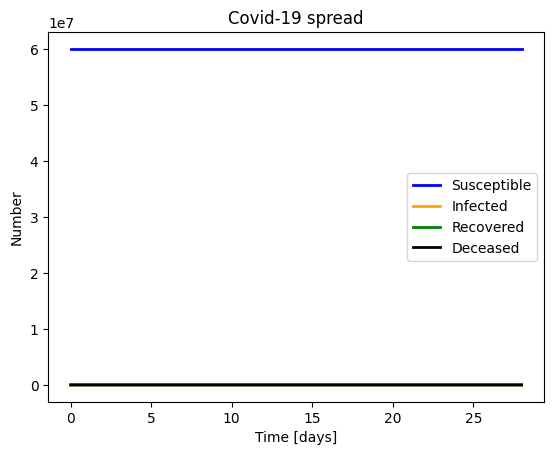

In [5]:
days = 28
model.solve(initial_conditions, days)
model.plot()
print()

In [11]:
model.soln

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  5.007e-01 ...  3.645e+02  3.650e+02]
        y: [[ 1.000e+00  9.999e-01 ...  1.070e-01  1.070e-01]
            [ 4.833e-05  5.108e-05 ...  3.667e-07  3.569e-07]
            [ 3.333e-07  2.111e-06 ...  8.670e-01  8.670e-01]
            [ 1.333e-06  1.387e-06 ...  2.601e-02  2.601e-02]]
      sol: None
 t_events: None
 y_events: None
     nfev: 122
     njev: 0
      nlu: 0

In [12]:
# Parameters after a simulation
params = model.get_params()
print(params)

{'S': 0.10701920085263186, 'I': 3.569322995756967e-07, 'R': 0.866970018331782, 'D': 0.02601042388328679}
